# gBizINFO API データ品質検証

このノートブックでは、経済産業省が提供するgBizINFO APIの**データ品質**を検証します。
具体的には、年によってデータ量の偏りがあるのかと言う点を明らかにします。

## 前提条件
- APIキーを取得済み
(以下の、経済産業省のAPI利用方法ページを参考にしてください。
https://info.gbiz.go.jp/api/index.html)

## 対象読者
- Pythonコードを理解できる方
- 生成AIツールを使用できる方（このプログラムをチャットの入力に使用してください）

In [ ]:
# 必要なライブラリのインストール
!pip install pandas numpy matplotlib requests tqdm

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
from tqdm.notebook import tqdm

# APIの基本設定
API_TOKEN = "YOUR_API_TOKEN"  # 実際のAPIトークンに置き換えてください
API_TOKEN = "Hgt7Gj3Il3rQovE8OiU817jgmrKe9jnM"  # テスト後に削除
BASE_URL = "https://info.gbiz.go.jp/hojin"
HEADERS = {"X-hojinInfo-api-token": API_TOKEN}

# APIリクエストの間隔（秒）- レート制限対策
REQUEST_INTERVAL = 0.5

print("API設定が完了しました")
print(f"Base URL: {BASE_URL}")

API設定が完了しました
Base URL: https://info.gbiz.go.jp/hojin


## 年ごとの件数の分布を取得
API利用中、各年で偏りを感じたので調査。

各年一様に分布していることを期待する。

- エンドポイント：
- 調査条件：平成28年1月（2016年1月）から前年までのデータ

> 出典：[G-Biz INFO FAQ](https://info.gbiz.go.jp/faq)

In [4]:
START_YEAR = 2016
END_YEAR = datetime.now().year-1

### 各年毎のデータ分布調査

In [12]:

def get_yearly_update_count(start_year=START_YEAR, end_year=END_YEAR):
    """
    updateInfoエンドポイントのみを使用して年次データ件数を取得
    
    Parameters:
    -----------
    start_year : int
        データ取得開始年（デフォルト: START_YEAR定数）
    end_year : int
        データ取得終了年（デフォルト: END_YEAR定数）
        
    Returns:
    --------
    dict
        年をキー、更新件数を値とする辞書
    """
    results = {}
    
    print("年次データ更新件数を取得中...")
    
    for year in range(start_year, end_year + 1):
        from_date = f"{year}0101"
        to_date = f"{year}1231"
        
        # updateInfoエンドポイントのみ使用
        url = f"{BASE_URL}/v1/hojin/updateInfo"
        params = {
            'from': from_date,
            'to': to_date,
            'page': 1,
            'limit': 1
        }
        
        try:
            response = requests.get(url, headers=HEADERS, params=params)
            
            if response.status_code == 200:
                data = response.json()
                count = int(data.get('totalCount', 0))
                results[year] = count
                print(f"{year}: {count:,} 件")
            else:
                print(f"エラー ({year}年): HTTPステータス {response.status_code}")
                results[year] = 0
                
            time.sleep(REQUEST_INTERVAL)
                
        except Exception as e:
            print(f"例外が発生しました ({year}年): {e}")
            results[year] = 0
    
    return results

# 年次データ数を取得（定数を使用）
yearly_counts = get_yearly_update_count(start_year=START_YEAR, end_year=END_YEAR)

# データフレームに変換して表示
df_yearly = pd.DataFrame.from_dict(yearly_counts, orient='index', columns=['Updates'])
df_yearly.index.name = 'Year'
print("\n年次別更新件数一覧:")
print(df_yearly)

年次データ更新件数を取得中...
2016: 151,081 件
2017: 135,005 件
2018: 585,068 件
2019: 497,342 件
2020: 430,561 件
2021: 417,239 件
2022: 401,821 件
2023: 434,293 件
2024: 493,582 件

年次別更新件数一覧:
      Updates
Year         
2016   151081
2017   135005
2018   585068
2019   497342
2020   430561
2021   417239
2022   401821
2023   434293
2024   493582


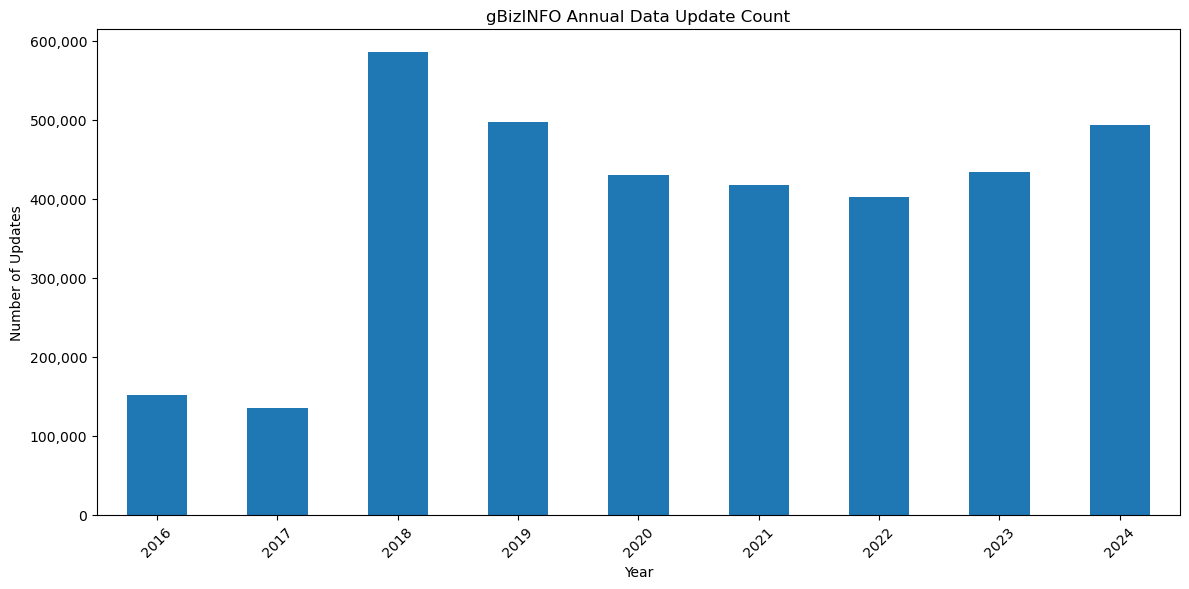

In [13]:

# グラフ作成
from matplotlib.ticker import FuncFormatter

def format_yaxis(x, pos):
    return '{:,.0f}'.format(x)

plt.figure(figsize=(12, 6))
df_yearly['Updates'].plot(kind='bar')
plt.title('gBizINFO Annual Data Update Count')
plt.xlabel('Year')
plt.ylabel('Number of Updates')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
